## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from yellowbrick.regressor import PredictionError, ResidualsPlot
import matplotlib.pyplot as plt
import seaborn as sns

## Define the files to be loaded

In [2]:
# Participant number whose data should be loaded
participant_number = 2

# The version of the questionnaires to load
quest_version = 2

## Loading the pre-processed data

In [3]:
# Complete dataset (Oura data + questionnaire data)
df = pd.read_csv('data/preprocessed/preprocessed_data_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df = df.drop(labels=['actual_day', 'actual_day.1'], axis=1)

# Oura dataset
df_oura = pd.read_csv('data/preprocessed/preprocessed_sleep_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_oura = df_oura.drop(labels=['actual_day'], axis=1)

# Questionnaire dataset
df_quest = pd.read_csv('data/preprocessed/preprocessed_questionnaires_' + str(participant_number) + '_v' + str(quest_version) + '.csv')
df_quest = df_quest.drop(labels=['actual_day'], axis=1)

In [4]:
# Remove these to try and fix the issues raised by LazyRegressor for them 
# example: 
# AdaBoostRegressor model failed to execute
# Found unknown categories ['[0.0, 51.0, 53.0, 53.0, 54.0, 53.0, ...
df = df.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)
df_oura = df_oura.drop(labels=['hrv.items', 'heart_rate.items', 'sleep_phase_5_min', 'movement_30_sec', 'segment_state', 'type'], axis=1)

In [5]:
# Replace NaN values by 999 because NaN values can raise errors when fed to a regression model
df.fillna(999, inplace=True)
df_oura.fillna(999, inplace=True)
df_quest.fillna(999, inplace=True)

## Define the analysis to be done

In [6]:
# For Oura sleep score
variable_of_interest = 'score'
oura_drop_variables = ['score']
quest_drop_variables = ['subjective_sleep_score']

# For Oura sleep score
# variable_of_interest = 'subjective_sleep_score'
# oura_drop_variables = ['score']
# quest_drop_variables = ['subjective_sleep_score']

# For average HRV
# variable_of_interest = 'average_hrv'
# oura_drop_variables = ['average_hrv']
# quest_drop_variables = []

## Apply Lasso

### Setting the data to be evaluated

In [7]:
# Separate the indenpendent variables from the dependent variables
y = df[variable_of_interest]
# Drop the necessary variables, including the dependent variable itself
X = df.drop(labels=oura_drop_variables+quest_drop_variables, axis=1)
X_oura = df_oura.drop(labels=oura_drop_variables, axis=1)
X_quest = df_quest.drop(labels=quest_drop_variables, axis=1)

### Defining the Lasso model

In [8]:
def lasso_model(X, y, random_state):
    # Standardizing the input variables
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Splitting train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = random_state)

    # Define model
    alphas = np.arange(0.01, 5, 0.01)
    model = LassoCV(alphas=alphas, cv=cv, max_iter=10000)

    model.fit(X_train, y_train)

    # Print search results
    print('Lasso CV results\nBest alpha value: %s\n' % model.alpha_)

    # Print training results with regards to the coefficients
    print("Number of coefficients", len(model.coef_))
    print("Non-zero coeffcients", np.count_nonzero(model.coef_))
    print("Coefficients", model.coef_)

    return model, X_train, X_test, y_train, y_test 

In [9]:
# Compute R squared and mean square error of a given model, for the training and testing sets 
def compute_model(model, X_train, y_train, X_test, y_test):
    # Training data
    print('R squared training set', round(model.score(X_train, y_train), 3))
    pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 3))

    # Test data
    print('\nR squared test set', round(model.score(X_test, y_test), 3))
    pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)
    print('MSE test set', round(mse_test, 3))

    return pred_train, pred_test

### Using as independent variables all variables (Oura + questionnaire data)

In [10]:
reg, X_train, X_test, y_train, y_test = lasso_model(X, y, random_state=np.random.randint(50000))

Lasso CV results
Best alpha value: 0.01

Number of coefficients 77
Non-zero coeffcients 16
Coefficients [-0.0096547  -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.02646124  0.          0.05471274
  0.04756084  0.0791716   0.07258847  0.25149478  0.          0.02469337
  0.         -0.          0.          0.         -0.         -0.
  0.          0.         -0.          0.00089836  0.31022714  0.
 -0.          0.0031386   0.         -0.         -0.          0.02462204
 -0.         -0.          0.          0.         -0.          0.
 -0.00134919 -0.         -0.06600825  0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.          0.         -0.          0.
  0.         -0.         -0.         -0.          0.00308224  0.
 -0.         -0.          0.          0.          0.          0.
  0.         -0.          0.         -0.00295769 -0.        ]


In [11]:
pred_train, pred_test = compute_model(reg, X_train, y_train, X_test, y_test)

R squared training set 0.996
MSE training set 0.002

R squared test set 0.995
MSE test set 0.003


In [12]:
# Return the absolute value of a value
def absvalue(value):
    return abs(value)

# Get all features that have a non-zero coefficient, along with their respective coefficient
def get_selected_features(X, reg):
    selected_features = []
    features_coef = []
    for i in range(len(reg.coef_)):
        # Only consider the variables that have not been eliminated in the L1 regularization phase
        if reg.coef_[i] != 0:
            selected_features.append(X.columns[i])
            features_coef.append(reg.coef_[i])

    print('Number of selected features', len(selected_features))
    print(selected_features)
    return selected_features, features_coef

# Sort the selected features by order of importance
def sort_features(X, reg):
    # Sort the coefficients in increasing order
    selected_features, features_coef = get_selected_features(X, reg)
    features_coef = sorted(features_coef, reverse=True, key = absvalue)
    original_coef = features_coef
    
    # Get the order of the features according to the importance of their coefficients
    indices = []
    for i in range(len(original_coef)):
        coeff = original_coef[i]
        index = features_coef.index(coeff)
        indices.append(index)

    # Order the names of the features accordingly
    sorted_features = []
    for i in range(len(indices)):
        index = indices.index(i)
        value = selected_features[index]
        sorted_features.append(value)
        
    return sorted_features, features_coef

In [13]:
sorted_features, features_coef = sort_features(X, reg)

Number of selected features 16
['average_breath', 'contributors.deep_sleep', 'contributors.latency', 'contributors.rem_sleep', 'contributors.restfulness', 'contributors.timing', 'contributors.total_sleep', 'efficiency', 'readiness.contributors.previous_day_activity', 'readiness.contributors.previous_night', 'readiness.contributors.sleep_balance', 'rem_sleep_duration', 'wake_ups', 'bed_time', 'alcohol_time', 'workout_intensity']


In [14]:
# Print the equation of how to predict the variable according to the model
def print_equation(sorted_features, features_coef):
    counter = 0
    equation = ''
    for i in range(len(sorted_features)):
        if counter != 0:
            equation += ' + '
        else:
            counter += 1
        equation += '(' + str(round(features_coef[i], 5)) + ' * ' + sorted_features[i] + ')'
    print(equation)

In [15]:
# Print the model equation for the computation of the dependent variable given all variables (Oura + questionnaire)
print_equation(sorted_features, features_coef)

(0.31023 * average_breath) + (0.25149 * contributors.deep_sleep) + (0.07917 * contributors.latency) + (0.07259 * contributors.rem_sleep) + (-0.06601 * contributors.restfulness) + (0.05471 * contributors.timing) + (0.04756 * contributors.total_sleep) + (0.02646 * efficiency) + (0.02469 * readiness.contributors.previous_day_activity) + (0.02462 * readiness.contributors.previous_night) + (-0.00965 * readiness.contributors.sleep_balance) + (0.00314 * rem_sleep_duration) + (0.00308 * wake_ups) + (-0.00296 * bed_time) + (-0.00135 * alcohol_time) + (0.0009 * workout_intensity)


### Visualizing the results
#### Plotting the actual test data points against the predicted data point

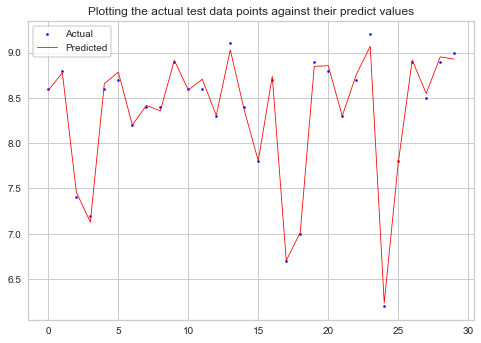

In [16]:
plt.style.use("seaborn-notebook")

x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="Actual")
plt.plot(x_ax, pred_test, lw=0.8, color="red", label="Predicted")
plt.title("Plotting the actual test data points against their predict values")
plt.legend(frameon=True, loc='best').get_frame().set_edgecolor('k')
plt.show()

#### Plotting the actual train data points against the predicted data point

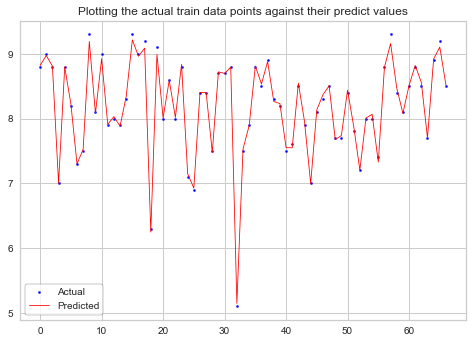

In [17]:
x_ax = range(len(X_train))
plt.scatter(x_ax, y_train, s=5, color="blue", label="Actual")
plt.plot(x_ax, pred_train, lw=0.8, color="red", label="Predicted")
plt.title("Plotting the actual train data points against their predict values")
plt.legend(frameon=True, loc='best').get_frame().set_edgecolor('k')
plt.show()

#### How off the predicted values were for the test set

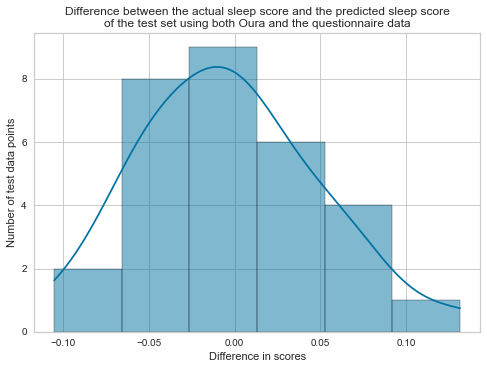

In [18]:
ax = sns.histplot(y_test-pred_test, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data points', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using both Oura and the questionnaire data')
plt.show()

#### Residuals plot
Residuals are the difference between the true value of the target variable and the predicted value. Thus, it is the error of the prediction. The difference between residuals is shown in a residuals plot, plotted against the predicted dependent variables along with the distribution of residuals.

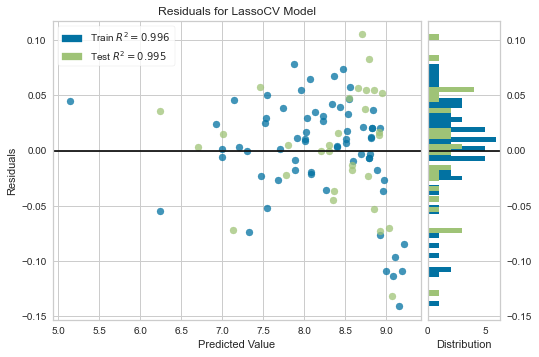

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [19]:
visualizer = ResidualsPlot(reg)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

#### Prediction error plot
It plots the actual targets from the dataset against the predicted values generated by the Lasso model, thereby showing how much variance is in the model.

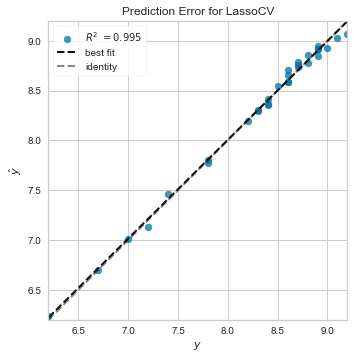

<AxesSubplot:title={'center':'Prediction Error for LassoCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [20]:
visualizer = PredictionError(reg)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

## Using as independent variables only the Oura data

In [21]:
reg_oura, X_train_oura, X_test_oura, y_train_oura, y_test_oura = lasso_model(X_oura, y, random_state=np.random.randint(50000))

Lasso CV results
Best alpha value: 0.01

Number of coefficients 45
Non-zero coeffcients 13
Coefficients [-9.54278437e-03 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  2.22769650e-02  5.57503277e-02
  5.89179740e-02  8.39946917e-02  6.97798141e-02  2.47700710e-01
  7.99526353e-05  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.62029860e-03
  2.90154938e-01 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.43969130e-04  2.53777946e-02 -0.00000000e+00 -0.00000000e+00
 -7.07540639e-02]


In [22]:
pred_train_oura, pred_test_oura = compute_model(reg_oura, X_train_oura, y_train_oura, X_test_oura, y_test_oura)

R squared training set 0.996
MSE training set 0.002

R squared test set 0.987
MSE test set 0.008


In [23]:
sorted_features_oura, features_coef_oura = sort_features(X_oura, reg_oura)

Number of selected features 13
['average_breath', 'contributors.efficiency', 'contributors.latency', 'contributors.rem_sleep', 'contributors.restfulness', 'contributors.timing', 'contributors.total_sleep', 'deep_sleep_duration', 'readiness.contributors.previous_day_activity', 'readiness.contributors.previous_night', 'timezone', 'total_sleep_duration', 'bed_time']


In [24]:
# Print the model equation for the computation of the dependent variable given the Oura variables
print_equation(sorted_features_oura, features_coef_oura)

(0.29015 * average_breath) + (0.2477 * contributors.efficiency) + (0.08399 * contributors.latency) + (-0.07075 * contributors.rem_sleep) + (0.06978 * contributors.restfulness) + (0.05892 * contributors.timing) + (0.05575 * contributors.total_sleep) + (0.02538 * deep_sleep_duration) + (0.02228 * readiness.contributors.previous_day_activity) + (-0.00954 * readiness.contributors.previous_night) + (0.00162 * timezone) + (-0.00064 * total_sleep_duration) + (8e-05 * bed_time)


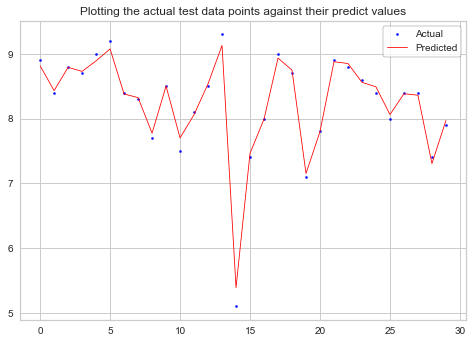

In [25]:
plt.style.use("seaborn-notebook")

# Visualization of the actual test data points vs the precited ones
x_ax = range(len(X_test_oura))
plt.scatter(x_ax, y_test_oura, s=5, color="blue", label="Actual")
plt.plot(x_ax, pred_test_oura, lw=0.8, color="red", label="Predicted")
plt.title("Plotting the actual test data points against their predict values")
plt.legend(frameon=True, loc='best').get_frame().set_edgecolor('k')
plt.show()

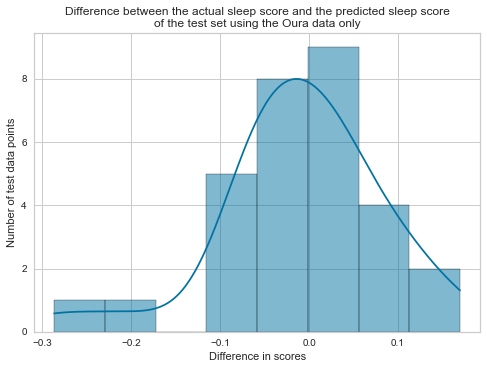

In [26]:
# How off the predicted values were for the test set
ax = sns.histplot(y_test_oura-pred_test_oura, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data points', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using the Oura data only')
plt.show()

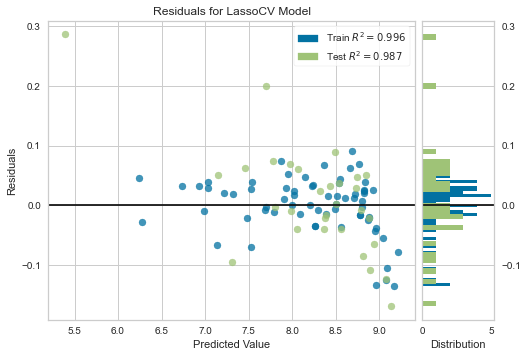

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [27]:
# Residuals Plot
visualizer = ResidualsPlot(reg_oura)
visualizer.fit(X_train_oura, y_train_oura)  
visualizer.score(X_test_oura, y_test_oura)  
visualizer.poof()

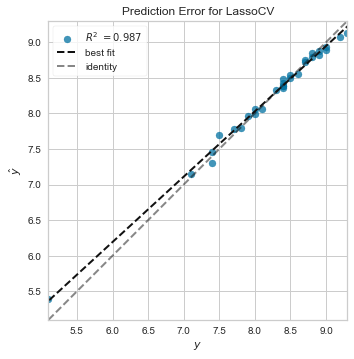

<AxesSubplot:title={'center':'Prediction Error for LassoCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [28]:
# Prediction Error Plot
visualizer = PredictionError(reg_oura)
visualizer.fit(X_train_oura, y_train_oura)  
visualizer.score(X_test_oura, y_test_oura)  
visualizer.poof()

## Applying the same model on the questionnaire data only

In [29]:
reg_quest, X_train_quest, X_test_quest, y_train_quest, y_test_quest = lasso_model(X_quest, y, random_state=np.random.randint(50000))

Lasso CV results
Best alpha value: 0.02

Number of coefficients 32
Non-zero coeffcients 16
Coefficients [ 1.32636243e-01  0.00000000e+00 -6.91233431e-02 -0.00000000e+00
 -1.12018184e-01 -0.00000000e+00  0.00000000e+00  1.06444906e-15
  0.00000000e+00 -8.85258590e-02  0.00000000e+00 -0.00000000e+00
  6.21040380e-02 -1.05328210e-02  5.22741838e-02  0.00000000e+00
 -8.33079828e-02 -2.30736735e-01 -1.97138115e-01  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  1.03019012e-01  1.32394274e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.87962902e-02
  1.63321828e-02  0.00000000e+00 -2.72037642e-02 -0.00000000e+00]


In [30]:
pred_train_quest, pred_test_quest = compute_model(reg_quest, X_train_quest, y_train_quest, X_test_quest, y_test_quest)

R squared training set 0.649
MSE training set 0.159

R squared test set 0.227
MSE test set 0.64


In [31]:
sorted_features_quest, features_coef_quest = sort_features(X_quest, reg_quest)

Number of selected features 16
['Comfort', 'I walked a bit', 'Naturally', 'With an alarm', 'prevent_early_sleep', 'prev_subjective_score', 'Mentally active', 'Physically active', 'Socially active', 'Stressful', 'alcohol_amount', 'eat_bedtime', 'intervention', 'special_circumstances', 'stress_levels', 'workout_intensity']


In [32]:
# Print the model equation for the computation of the dependent variable given the questionnaire variables 
print_equation(sorted_features_quest, features_coef_quest)

(-0.23074 * Comfort) + (-0.19714 * I walked a bit) + (0.13264 * Naturally) + (0.13239 * With an alarm) + (-0.11202 * prevent_early_sleep) + (0.10302 * prev_subjective_score) + (-0.08853 * Mentally active) + (-0.08331 * Physically active) + (-0.06912 * Socially active) + (0.0621 * Stressful) + (0.05227 * alcohol_amount) + (-0.0288 * eat_bedtime) + (-0.0272 * intervention) + (0.01633 * special_circumstances) + (-0.01053 * stress_levels) + (0.0 * workout_intensity)


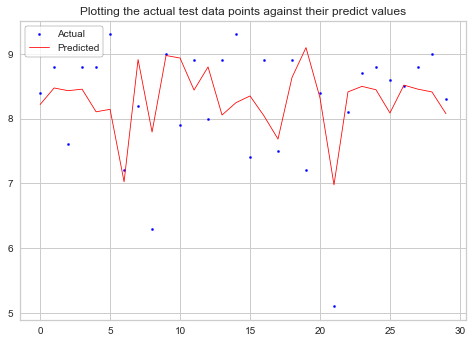

In [33]:
plt.style.use("seaborn-notebook")

# Visualization of the actual test data points vs the precited ones
x_ax = range(len(X_test_quest))
plt.scatter(x_ax, y_test_quest, s=5, color="blue", label="Actual")
plt.plot(x_ax, pred_test_quest, lw=0.8, color="red", label="Predicted")
plt.title("Plotting the actual test data points against their predict values")
plt.legend(frameon=True, loc='best').get_frame().set_edgecolor('k')
plt.show()

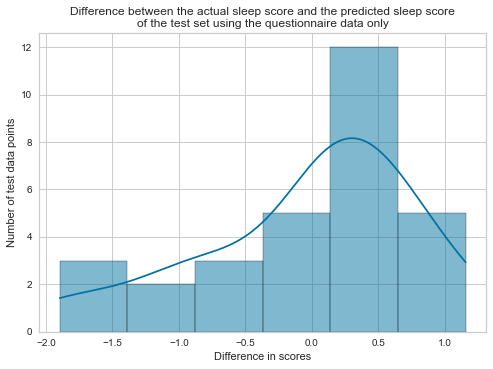

In [34]:
# How off the predicted values were for the test set
ax = sns.histplot(y_test_quest-pred_test_quest, kde=True)
ax.set(xlabel='Difference in scores', ylabel='Number of test data points', 
       title='Difference between the actual sleep score and the predicted sleep score\nof the test set using the questionnaire data only')
plt.show()

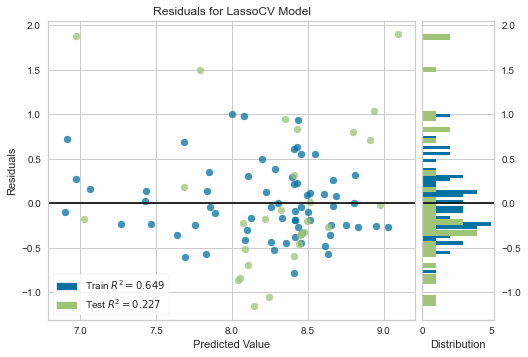

<AxesSubplot:title={'center':'Residuals for LassoCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [35]:
# Residuals Plot
visualizer = ResidualsPlot(reg_quest)
visualizer.fit(X_train_quest, y_train_quest)  
visualizer.score(X_test_quest, y_test_quest)  
visualizer.poof()

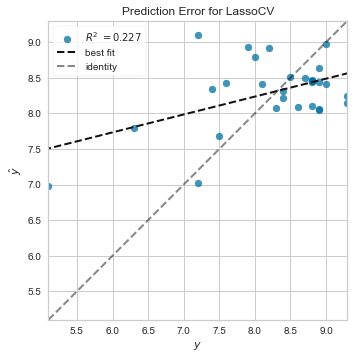

<AxesSubplot:title={'center':'Prediction Error for LassoCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [36]:
# Prediction Error Plot
visualizer = PredictionError(reg_quest)
visualizer.fit(X_train_quest, y_train_quest)  
visualizer.score(X_test_quest, y_test_quest)  
visualizer.poof()